# CLIP : zero shot classification

![OpenAI](./imgs/open_ai_logo.png)

notebook author: Jan D'Espallier Lector UCLL

inspiration from : https://youtu.be/8o701AEoZ8I (notebook in comments below youtube.)

## CLIP: What is it? How does it work?

[CLIP](https://openai.com/blog/clip/) is a zero shot image classifier relased by OpenAI early 2021. It has been trained on 400 million text/image pairs across the web. CLIP uses these learnings to make predicts based on a flexible span of possible classification categories.

CLIP is a zero-shot model — meaning that (once it’s trained), it can recognize and relate **new concepts** without any additional task-specific training.

You can find the clip paper [here](https://arxiv.org/abs/2103.00020)

How good is clip for classification? see [this report](https://ucladeepvision.github.io/CS188-Projects-2024Winter/2024/03/22/team43-zero-shot-classification.html)

## How this notebook works
In this notebook you'll find cells that start with a ❓. These cells contain a question or a task. Insert an extra cell after these and either formulate an answer or fill in some code. After the workshop you'll get the fully completed notebook, such that you can use it @home to see potential solutions.

## Clip in action
This notebook provides an example of how to benchmark CLIP's zero shot classification performance on your own classification dataset.
Try it out on your own task here!
Be sure to experiment with various text prompts to unlock the richness of CLIP's pretraining procedure.

Note: this notebook supports 2 modes in which CLIP technology can be used :
- CLIP running locally on your laptop
- CLIP (or alike) running on the servers of openai. ( ~ chatgpt )

In [28]:
# select the technology you want to evaluate
tech_2_use_for_classification='local_clip'
# note ...at this moment this notebook only supports 1 technology, later you will be asked to add another one.

### Setting up your environment

This notebook has been test in an anaconda environment on windows with python 3.12.11 installed
It should run as well on Linux and or with other versions of python as long as the correct packages have been installed.

This notebook is designed to run on a laptop with or without GPU capabilities.
When you have a GPU available :
- pip install cuda-python
- pip install torch torchvision --index-url https://download.pytorch.org/whl/cu124

Otherwise
- pip install torch
- pip install torchvision
- pip install ftfy
- pip install regex
  

In [3]:
test_cuda_support=True
if test_cuda_support :
   import torch
   import subprocess
   print("PyTorch CUDA available ?:", torch.cuda.is_available())
   if torch.cuda.is_available():
       torch.zeros(1).cuda()
       print("CUDA Version:", torch.version.cuda)
       print("Available GPUs:", torch.cuda.device_count())
       print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
       # verify which cuda version you are using
       CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
       print("CUDA version:", CUDA_version)

PyTorch CUDA available ?: True
CUDA Version: 12.6
Available GPUs: 1
GPU Name: Tesla T4
CUDA version: 12.5


In [4]:
# General import section
import sys
import os
import numpy as np
import cv2
import torch
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
from PIL import Image

### General configuration

In [5]:
verbose=True
visualise=True
visualise_mis_classifications=True

### General helper functions

In [6]:
def displayPerformanceFigures(real,pred,title,classnames,includeCF=True):
   if includeCF:
       # Compute confusion matrix
       cm = confusion_matrix(real, pred)
       sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classnames, yticklabels=classnames)
       plt.xlabel('Predicted labels')
       plt.ylabel('True labels')
       plt.title('Confusion Matrix for '+title+' samples')
       plt.show()

   acc= accuracy_score(real, pred)
   print(f'Accuracy: {acc:.2f}')

   f1 = f1_score(real, pred, average='macro')
   print(f'F1 score: {f1:.2f}')

In [7]:
def showImage(img_path, pred=None):
    """
    Display an image with an optional prediction label overlay using matplotlib.
    """
    # Load the image with OpenCV (BGR format)
    cv_img = cv2.imread(img_path)

    if cv_img is None:
        print(f"Error: Unable to load image at {img_path}")
        return

    # Convert BGR (OpenCV default) to RGB (matplotlib expects RGB)
    cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)

    # Resize for display
    cv_img = cv2.resize(cv_img, (300, 300))

    # Plot using matplotlib
    plt.figure(figsize=(4, 4))
    plt.imshow(cv_img)
    plt.axis('off')

    # Add text overlay (title or annotation)
    if pred is not None:
        plt.title(f"Pred: {pred}", fontsize=12, color='red')

    plt.show()

### Preparation of the data to be used
This notebook allows one to use different databases to test the image classifiers.
- 'cat_vs_dog'         see [here](https://www.kaggle.com/datasets/karakaggle/kaggle-cat-vs-dog-dataset)
- 'cifar_10'           see [here](https://www.tensorflow.org/datasets/catalog/cifar10)
- 'mnist_digits'       see [here](https://keras.io/api/datasets/mnist/)
- 'tensor_flow_flowers'see [here](https://www.tensorflow.org/datasets/catalog/tf_flowers)
- 'primagaz'      see workshops ai applications 2025/2026
- 'eyes4rescue'   see workshops ai applications 2024/2025

In [73]:
db2use='tensorflow_flowers'
# db2use='cat_vs_dog'
#db2use='cifar_10'
#db2use='mnist_digits'
#db2use='primagaz' ?

❓ 1 Indicate 'where' you want to store/ have stored the images for this exercise (e.g c:\\data ..or alike)
This directory can/will hold multiple datasets later on.

In [78]:
my_data_dir="/root/datadir"
print(my_data_dir)

/root/datadir


In [74]:
if db2use=='cat_vs_dog':
  import kagglehub

  # Download latest version
  path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")

  print("Path to dataset files:", path)
  my_data_dir = path

In [ ]:
# The idea is that you make sure that the data ends up in a structure similar to the following one (assuming the classes are [cats,dogs,horses']
structure="""
datasetlocation/
├── cats/
│   ├── cat001.jpg
│   ├── cat002.png
│   └── ...
├── dogs/
│   ├── dog001.jpg
│   ├── dog002.png
│   └── ...
└── horses/
    ├── horse001.png
    └── ...
"""

# the variables that should be set in the end is datasetlocation
# it has to point at the toplevel dir holding your class sudirectories.

❓ 2 in function of the database of you have chosen...complete/improve the candidate_captions...  Note that the beterre the captions are , the better CLIP may perform.

#### Tensorflow Flowers

In [80]:
if db2use == 'tensorflow_flowers':
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # Choose your own directory
    target_root =  os.path.join(my_data_dir,"computer_vision")

    tf.keras.utils.get_file(
        fname='flower_photos',                    # base name of file/folder
        origin=dataset_url,                       # download source
        untar=True,                               # extract after download
        cache_dir=target_root,                    # where to put it
        cache_subdir="",                          # optional: no extra nested folder
    )
    datasetlocation = os.path.join(target_root,'flower_photos','flower_photos')
    class_names = [
    name for name in os.listdir(datasetlocation)
    if os.path.isdir(os.path.join(datasetlocation, name))
    ]
    if tech_2_use_for_classification=='local_clip':
        candidate_captions=[]
        for i in range(len(class_names)):
            candidate_captions.append(class_names[i])

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


#### MNIST Digits

In [ ]:
if db2use=='mnist_digits':
    #datasetlocation='C:\\data\\computer_vision\\mnist_digits'
    datasetlocation = os.path.join(my_data_dir,"computer_vision","mnist_digits")
    if tech_2_use_for_classification=='local_clip':
        candidate_captions=[]
        for i in range(10) :
            candidate_captions.append(...)

Make sure you have the MNIST images available somewhere on your hardrive (execute once only)

In [ ]:
i_have_the_mnist_data_already=True
if db2use=='mnist_digits' and not i_have_the_mnist_data_already:
    # create an image dir with 10 subdirs named 0 to 9 with in each dir x images of handwritten digits from the mnist db.
    mnist = tf.keras.datasets.mnist # We load our data
    (x_train, y_train),(x_test, y_test) = mnist.load_data()

    # create 10 subdirs named 0 to 9
    for d in range(10):
        os.makedirs(os.path.join(datasetlocation, str(d)), exist_ok=True)

    # dump an image of the 200 first images in their subdir
    for i in range(200):
        im = x_train[i]  # the image (28x28 numpy array)
        label = y_train[i]  # the digit label (0–9)

        # Define filename
        filename = os.path.join(
            datasetlocation, str(label), f"id_{i}_digit_{label}.png"
        )
        # Convert to PIL image and save as PNG
        Image.fromarray(im).save(filename)

    print("Saved first 200 MNIST images into subdirectories.")

#### CIFAR-10

In [ ]:
if db2use=='cifar_10':
    #datasetlocation='C:\\data\\computer_vision\\cifar_10'
    datasetlocation = os.path.join(my_data_dir,"computer_vision","cifar_10")
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    if tech_2_use_for_classification=='local_clip':
        candidate_captions=[]
        for i in range(10) :
            candidate_captions.append(...)

In [ ]:
i_have_the_cifar_data_already=True
if db2use=='cifar_10'and not i_have_the_cifar_data_already :
    from tensorflow.keras.datasets import cifar10

    # Load CIFAR-10 data
    (x_train, y_train), (x_tst, y_tst) = cifar10.load_data()
    print('train:'+str(x_train.shape))
    print('val:'+str(x_tst.shape))

    # create 10 subdirs named with the labels
    for c in range(10):
        os.makedirs(os.path.join(datasetlocation, class_names[c]), exist_ok=True)

    # dump an image of the 200 first images in their subdir
    for i in range(200):
        im = x_train[i]  # the image
        label = class_names[y_train[i][0]]  # y_train holds a list of label_ids of the objects in the image, we assume the first one is the one.
        # Define filename
        filename = os.path.join(
            datasetlocation, str(label), f"id_{i}_{label}.png"
        )
        # Convert to PIL image and save as PNG
        Image.fromarray(im).save(filename)

    print("Saved first 200 CIFAR_10 images into subdirectories.")

#### Kaggle CAT vs Dog

In [65]:
if db2use=='cat_vs_dog':
    datasetlocation = os.path.join(my_data_dir,"kagglecatsanddogs_3367a","PetImages")
    if tech_2_use_for_classification=='local_clip':
        candidate_captions=['Dog',
                            'Cat']

## Data inspection

In [81]:
class_names = [
    name for name in os.listdir(datasetlocation)
    if os.path.isdir(os.path.join(datasetlocation, name))
]

❓ 3: Which classes do we have?

In [82]:
class_names

['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']

❓ 4: Which captions do we have? (in case clip is used)

In [83]:
if tech_2_use_for_classification=='local_clip':
    print(candidate_captions)

['roses', 'daisy', 'dandelion', 'sunflowers', 'tulips']


❓ 5 : plot an example image 1 from each class.

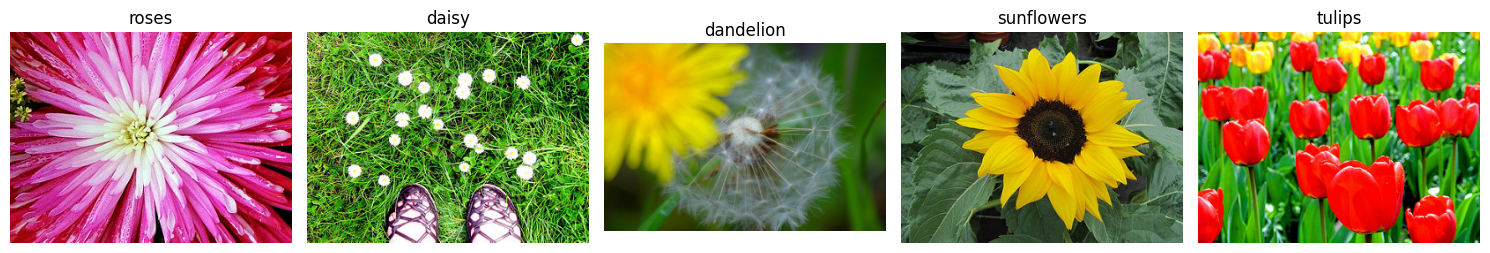

In [84]:
import random
import matplotlib.image as mpimg

plt.figure(figsize=(15, 5))

for i, cls in enumerate(class_names):
    class_path = os.path.join(datasetlocation, cls)

    # List all image files (common extensions)
    img_files = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff', '.webp'))
    ]

    if not img_files:
        print(f"No images found in {class_path}")
        continue

    # Pick one random image
    img_file = random.choice(img_files)
    img_path = os.path.join(class_path, img_file)

    # Read and plot
    img = mpimg.imread(img_path)
    plt.subplot(1, len(class_names), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(cls)
plt.tight_layout()
plt.show()

### Prepare for (one of) the 2 technologies used

#### CLIP

In [46]:
import subprocess
import os

repo_url = "git+https://github.com/openai/CLIP.git"

try:
    subprocess.run(
        ["pip", "install", repo_url],
        check=True
    )
except subprocess.CalledProcessError as e:
    print(f"Failed to clone repository: {e}")


In [47]:
if tech_2_use_for_classification=='local_clip':
    # make sure the clip module will be found by adding it to the path
    # Define the relative or absolute path where `clip` is located
    import clip

❓ 6 Choose a model in function of (cpu_at_hand_; time_you_have ; performance required)

In [48]:
if tech_2_use_for_classification=='local_clip':
    # Vit = Vision Transformer (ViT) Models other option is ResNet (CNN models)
    #model2use="ViT-B/32"       # 342 M
    #model2use="ViT-B/16"       # 345 M
    #model2use="ViT-L/14"       # 910 M   Larger model with a patch size of 14, providing enhanced performance.
    model2use="ViT-L/14@336px"  # 912 M   Similar to ViT-L/14 but trained on higher resolution images (336x336 pixels).

In [85]:
if tech_2_use_for_classification=='local_clip':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, transform = clip.load(model2use, device=device)

    text = clip.tokenize(candidate_captions).to(device)

In [57]:
if tech_2_use_for_classification=='local_clip':
   def argmax(iterable):
        return max(enumerate(iterable), key=lambda x: x[1])[0]

   def predict_class_from_image(img,classnames):
        image = transform(Image.open(img)).unsqueeze(0).to(device)
        with torch.no_grad():
            logits_per_image, _ = model(image, text)
            #if verbose:print(logits_per_image)
            probs = logits_per_image.softmax(dim=-1).cpu().numpy()
            #if verbose:print(probs)
            print(probs)
            pred = class_names[argmax(list(probs)[0])]
        return pred

## Main loop

classifying: 5 images from class: roses
/root/datadir/computer_vision/flower_photos/flower_photos/roses/2980099495_cf272e90ca_m.jpg
[[0.858   0.00502 0.01584 0.02199 0.0993 ]]
roses
/root/datadir/computer_vision/flower_photos/flower_photos/roses/5231103167_a03280e9f6_n.jpg
[[9.980e-01 1.304e-03 9.149e-05 3.874e-05 6.762e-04]]
roses
/root/datadir/computer_vision/flower_photos/flower_photos/roses/9216324117_5fa1e2bc25_n.jpg
[[9.941e-01 4.022e-04 1.785e-04 4.630e-04 4.902e-03]]
roses
/root/datadir/computer_vision/flower_photos/flower_photos/roses/8983268106_dc913d17d8_m.jpg
[[9.922e-01 5.806e-03 2.288e-04 2.416e-04 1.613e-03]]
roses
/root/datadir/computer_vision/flower_photos/flower_photos/roses/5398569540_7d134c42cb_n.jpg
[[9.385e-01 4.802e-04 1.285e-03 3.386e-03 5.637e-02]]
roses
classifying: 5 images from class: daisy
/root/datadir/computer_vision/flower_photos/flower_photos/daisy/43474673_7bb4465a86.jpg
[[6.199e-06 9.971e-01 3.075e-03 1.591e-05 5.186e-06]]
daisy
/root/datadir/computer

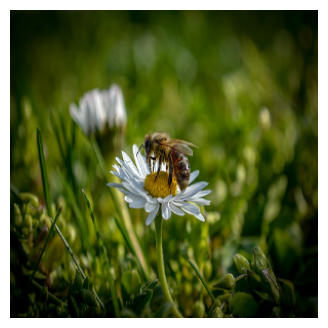

daisy
/root/datadir/computer_vision/flower_photos/flower_photos/dandelion/14048849371_ec9dbafaeb_m.jpg
[[5.722e-06 7.095e-04 9.990e-01 1.162e-05 8.881e-06]]
dandelion
classifying: 5 images from class: sunflowers
/root/datadir/computer_vision/flower_photos/flower_photos/sunflowers/7586498522_4dcab1c8d2_m.jpg
[[1.973e-05 1.280e-03 3.645e-03 9.951e-01 3.034e-05]]
sunflowers
/root/datadir/computer_vision/flower_photos/flower_photos/sunflowers/2598973480_07de93e91d_n.jpg
[[1.312e-04 4.654e-04 4.464e-05 9.990e-01 1.767e-04]]
sunflowers
/root/datadir/computer_vision/flower_photos/flower_photos/sunflowers/6133988570_9dc778e622_m.jpg
[[1.179e-03 6.474e-03 6.614e-04 9.912e-01 3.028e-04]]
sunflowers
/root/datadir/computer_vision/flower_photos/flower_photos/sunflowers/15122112402_cafa41934f.jpg
[[1.537e-03 3.986e-03 2.321e-04 9.912e-01 3.057e-03]]
sunflowers
/root/datadir/computer_vision/flower_photos/flower_photos/sunflowers/15054752730_fcf54d475e_m.jpg
[[1.020e-04 2.113e-03 9.089e-04 9.966e-01 7

In [86]:
max_nbr_imgs_per_class=5

actual   = []
predicted= []

exts = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif', '*.tiff', '*.webp')

for cls in class_names:
    test_imgs = []
    for ext in exts:
        test_imgs.extend(glob.glob(os.path.join(datasetlocation, cls, ext)))

    print(f'classifying: {min(len(test_imgs),max_nbr_imgs_per_class)} images from class: {cls}')
    for img_path in test_imgs[:max_nbr_imgs_per_class]:
        if verbose:print(img_path)
        pred=predict_class_from_image(img_path,class_names)
        if visualise_mis_classifications :
            if pred != cls :
                showImage(img_path)
        actual.append(cls)
        predicted.append(pred)
        if verbose: print(pred)

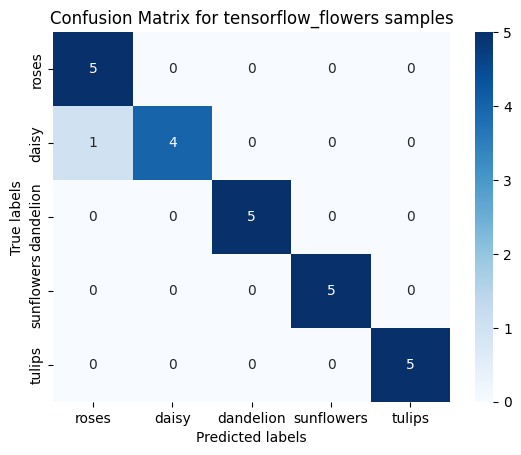

Accuracy: 0.96
F1 score: 0.96


In [87]:
displayPerformanceFigures(actual,predicted,db2use,class_names,includeCF=True)

## Results achieved

❓ 7: Try to generate performance figures for some databases and leave here a trace of the performances achieved.
Db's you could use :
- MNIST data
- CIFAR_10
- Tensorflow flowers
- cat vs dog
- ....gas bottle images...?
- or any other fun datasets you can get your hands on

Compare the CLIP performance with the performance of other computer vision techniques we have used before , like
- self made shallow neural nets
- self made convolutional nets
- transfer learning with keras applications (mobilenet, exception  etc..)

Use performance numbers in tables (1 table (?) per image set you evaluated)  such that its easy to keep the overview of all performances.

Don't forget to mention for the CLIP performance which model was used + wat the set of captions was that you used.

With Dogs vs Cats it achieved 100% accuracy. which is way better than our previous tries with different neural networks. I decided to tensor flowers dataset to compare results easily. As you can see it achieves 96% accuracy which is higher than all my previous results (As I can see the maximum I was able to reach before was 88% accuracy)